# Load libraries 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable


#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy/")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs
from   SEA import SEA

# Better figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True

This unreleased version of SpacePy is not supported by the SpacePy team.


# Download data
    Notes:
    - When you request magnetic field data with a resolution (dt) greater than 250 ms, lower resolution data will be downloaded. This is preferred in cases where you want to synchronize magnetic and particle data to mitigate aliasing.
    - SCAM for PSP does not work great because it doesnt download all the files needed (Fix!)
    

In [4]:
# Choose PSP or SolO
sc                      = 0                                    # PSP:0, SolO:1

# If you only need to download 1 interval (dates wont matter if only_one_interval=0)
only_one_interval       = 1                                    # If you only want to check one interval
if sc==0:
    vars_2_downnload = {'mag': None, 'span': None,'span-a': None, 'spc': None, 'qtn': None, 'ephem': None}
    
elif sc==1:
    vars_2_downnload = {'mag': None, 'qtn': None, 'swa': None, 'ephem': None} 
else:
    print('Not ready yet!')
    
starting_date           = '2018-11-02 00:10:10'                  # Define starting and ending date of the interval
ending_date             = '2018-11-04 15:01:51'

# on the other hand if you have a list of intervals
load_path               = '/Users/nokni/work/MHDTurbPy/example/' # In case you have multiple days you want to download ()


cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path
choose_working_dir      = '/Users/nokni/work/sc_data/'           # Working dir. Usually where you save raw data (a psp_data, and/or solar_orbiter_data folder will be created)
save_path               = 'data/'                                # This will be connected with the parent of load_path

#User defined parameters
addit_time_around       =  12                                     # [start_time -addit_time_around [h], end_time + addit_time_around [h]]
high_resol_data         = True
subtract_rol_mean       = 1                                      # To estimate fluctuations of mag, vel field
rolling_window          = '1h'                                   # When estimating fluctuations, size of window (centered around -w/2 -w/2
gap_time_threshold      = 5                                      # Threshold for large gaps (units of seconds)
estimate_PSD            = 0                                      # Estimate magentic field powes spectral density (keep false)
estimate_PSD_V          = 0                                      # Estimate velocity field powes spectral density (keep false)
high_res_mag            = 0                                      # Use high resol or low resolution magnetic field data ( Choose either 1 or 0 respectively)
in_RTN                  = 1                                      # RTN or spacecraft frame ( We will usually use RTN)
f_min_spec              = 2e-3                                   # Integrate over [f_min_spec, f_max_spec]to estimate σc, σr 
f_max_spec              = 1e-2                                   #
step                    = '12H'                                  # Move starting point by step (in Hours)
duration                = '24H'                                  # Duration of interval (in Hours)
settings                =  {
                            'particle_mode': '9th_perih_cut',    # either: 'spc', 'span', '9th_perih_cut'
                            'use_hampel'   : False,              # Use hampelfilter to despike plasma data
                            'part_resol'   : 600,                # Max resol of plasma data                [ms]
                            'MAG_resol'    : 50                   # Max resol og magnetic field data        [ms]

                            } 
# credentials              =  { 'psp':
#                                   {
#                                      'fields': {'username': 'none', 'password': 'none'},
#                                      'sweap' : {'username': 'none', 'password': 'none'}
#                                   }
#                               }
credentials         = { 'psp':{
                               'fields': {'username': 'mvelli', 'password': 'flds@psp'},
                               'sweap' : {'username': 'mvelli', 'password': '2019swe@pd@ta'}
                              }
                      }

# Change to to specified working dir
os.chdir(choose_working_dir)

if only_one_interval:
    df                      =  pd.DataFrame(    index = np.arange(1),
                                                data  = { 'Start' : pd.Timestamp(starting_date), 
                                                          'End'   : pd.Timestamp(ending_date)}
                                           )
else:
    df                      =  pd.read_pickle(load_path)

# Define final path

final_path              =  Path(load_path).joinpath(save_path)

# Run main loop
for ok in range(0,len(df)):
    # Print progress
    func.progress_bar(ok, len(df))

    t0 = df['Start'][ok]
    t1 = df['End'][ok]

    """Setup for main function"""
    tstarts, tends, tfmt, path0  = calc.set_up_main_loop(final_path, only_one_interval,t0, t1, step, duration)

    # Load dist_df of SolO. Stupid way to do it fix later!!
    dist_df            = pd.read_pickle(str(Path(load_path).joinpath("ephem_data").joinpath("SolO_ephem.pkl")))

    """ Now run main for loop! """
    for i1 in range(len(tstarts)):
        start_time  = tstarts[i1]
        end_time    = tends[i1]
        
        # Define folder name
        foldername  = "%s_%s_sc_%d" %(str(start_time.strftime(tfmt)), str(end_time.strftime(tfmt)), 0)

        if not os.path.exists(path0.joinpath(foldername)):
            # Running the main function
            big_gaps, flag_good, final, general, sig_c_sig_r_timeseries, dfdis = calc.final_func(
                                                                                            start_time         , 
                                                                                            end_time           , 
                                                                                            addit_time_around  ,
                                                                                            settings           , 
                                                                                            vars_2_downnload   ,
                                                                                            cdf_lib_path       ,
                                                                                            credentials        ,
                                                                                            gap_time_threshold ,
                                                                                            estimate_PSD_V     ,
                                                                                            subtract_rol_mean  ,
                                                                                            rolling_window     ,
                                                                                            f_min_spec         ,
                                                                                            f_max_spec         ,  
                                                                                            estimate_PSD       , 
                                                                                            sc                 , 
                                                                                            high_resol_data    ,
                                                                                            in_RTN             ,
                                                                                          )
            try:
                final['Par']['V_resampled'] = final['Par']['V_resampled'].join(func.newindex(dfdis[['sc_vel_r', 'sc_vel_t', 'sc_vel_n']], final['Par']['V_resampled'].index))

            except:
                pass

            if flag_good == 1:# (save...)

                if os.path.exists(path0.joinpath(foldername)):
                    print("%d out of %d finished" %(i1, len(df)))
                    continue
                try:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)

                    pickle.dump(final,open(path0.joinpath(foldername).joinpath("final_data.pkl"),'wb'))
                    pickle.dump(general,open(path0.joinpath(foldername).joinpath("general.pkl"),'wb'))
                    pickle.dump(sig_c_sig_r_timeseries,open(path0.joinpath(foldername).joinpath("sig_c_sig_r.pkl"),'wb'))

                except:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)
                    print("%s - %s failed!" %(i1, len(tstarts)))

                print("%d out of %d finished" %(i1, len(tstarts)))
            else:
                os.makedirs(path0.joinpath(foldername), exist_ok=True)
                print("%s - %s failed!" %(i1, len(tstarts)))            

21-Feb-23 04:56:10: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110112_v02.cdf
21-Feb-23 04:56:10: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110118_v02.cdf


Completed 0.0


21-Feb-23 04:56:10: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110200_v02.cdf
21-Feb-23 04:56:10: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110206_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110212_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110218_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110300_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110306_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110312_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110318_v02.cdf
21-Feb-23 04:56:11: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110400_v02.cdf
21-Feb-23 

21-Feb-23 04:57:42: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110206_v02.cdf
21-Feb-23 04:57:42: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110212_v02.cdf
21-Feb-23 04:57:42: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110218_v02.cdf
21-Feb-23 04:57:42: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110300_v02.cdf
21-Feb-23 04:57:42: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110306_v02.cdf
21-Feb-23 04:57:42: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110312_v02.cdf
21-Feb-23 04:57:43: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110318_v02.cdf
21-Feb-23 04:57:43: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110400_v02.cdf
21-Feb-23 04:57:43: File is current: psp_data/fields/l2/mag_RTN/2018/11/psp_fld_l2_mag_RTN_2018110406_v02.cdf
21-Feb-23 

21-Feb-23 04:59:33: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181101_v04.cdf
21-Feb-23 04:59:34: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181102_v04.cdf
21-Feb-23 04:59:34: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181103_v04.cdf
21-Feb-23 04:59:34: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181104_v04.cdf
21-Feb-23 04:59:34: File is current: psp_data/sweap/spi/L3/spi_sf00/2018/11/psp_swp_spi_sf00_L3_mom_20181105_v04.cdf
21-Feb-23 04:59:34: Time clip was applied to: psp_spi_DENS
21-Feb-23 04:59:34: Time clip was applied to: psp_spi_VEL_RTN_SUN
21-Feb-23 04:59:34: Time clip was applied to: psp_spi_TEMP
21-Feb-23 04:59:34: Time clip was applied to: psp_spi_SUN_DIST
21-Feb-23 04:59:34: Time clip was applied to: psp_spi_SC_VEL_RTN_SUN
21-Feb-23 04:59:34: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spi/L3/sp

21-Feb-23 04:59:35: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181101_v04.cdf
21-Feb-23 04:59:35: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181102_v04.cdf
21-Feb-23 04:59:35: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181103_v04.cdf
21-Feb-23 04:59:35: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181104_v04.cdf
21-Feb-23 04:59:35: File is current: psp_data/sweap/spi/L3/spi_sf0a/2018/11/psp_swp_spi_sf0a_L3_mom_20181105_v04.cdf
21-Feb-23 04:59:35: Time clip was applied to: psp_spi_DENS
21-Feb-23 04:59:35: /Users/nokni/work/MHDTurbPy/functions/general_functions.py:466: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  r8   = df.index.unique().get_loc(t0, method='nearest');

21-Feb-23 04:59:35: /Users/nokni/work/MHDTurbPy/functions

Using LEVEL=L3 (unpublished)


21-Feb-23 04:59:36: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181101_v01.cdf
21-Feb-23 04:59:36: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181102_v01.cdf
21-Feb-23 04:59:36: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181103_v01.cdf
21-Feb-23 04:59:36: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181104_v01.cdf
21-Feb-23 04:59:36: File is current: psp_data/sweap/spc/L3/2018/11/psp_swp_spc_l3i_20181105_v01.cdf
21-Feb-23 04:59:40: Time clip was applied to: psp_spc_np_moment
21-Feb-23 04:59:41: Time clip was applied to: psp_spc_wp_moment
21-Feb-23 04:59:42: Time clip was applied to: psp_spc_vp_moment_RTN
21-Feb-23 04:59:42: Time clip was applied to: psp_spc_sc_pos_HCI
21-Feb-23 04:59:43: Time clip was applied to: psp_spc_carr_longitude
21-Feb-23 04:59:44: Time clip was applied to: psp_spc_na_fit
21-Feb-23 04:59:46: /Users/nokni/work/MHDTurbPy/functions/general_functions.py:466: FutureWarning: Passing me

Using LEVEL=L3


21-Feb-23 04:59:46: File is current: psp_data/fields/l3/sqtn_rfs_V1V2/2018/11/psp_fld_l3_sqtn_rfs_V1V2_20181103_v1.0.cdf
21-Feb-23 04:59:46: File is current: psp_data/fields/l3/sqtn_rfs_V1V2/2018/11/psp_fld_l3_sqtn_rfs_V1V2_20181104_v1.0.cdf
21-Feb-23 04:59:46: File is current: psp_data/fields/l3/sqtn_rfs_V1V2/2018/11/psp_fld_l3_sqtn_rfs_V1V2_20181105_v1.0.cdf
21-Feb-23 04:59:47: Time clip was applied to: electron_density
21-Feb-23 04:59:47: Time clip was applied to: electron_core_temperature
21-Feb-23 04:59:47: /Users/nokni/work/MHDTurbPy/functions/general_functions.py:466: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  r8   = df.index.unique().get_loc(t0, method='nearest');

21-Feb-23 04:59:47: /Users/nokni/work/MHDTurbPy/functions/general_functions.py:467: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_

21-Feb-23 04:59:47: File is current: psp_data/fields/l1/ephem_spp_rtn/2018/11/spp_fld_l1_ephem_spp_rtn_20181103_v01.cdf
21-Feb-23 04:59:47: File is current: psp_data/fields/l1/ephem_spp_rtn/2018/11/spp_fld_l1_ephem_spp_rtn_20181104_v01.cdf
21-Feb-23 04:59:47: File is current: psp_data/fields/l1/ephem_spp_rtn/2018/11/spp_fld_l1_ephem_spp_rtn_20181105_v01.cdf
21-Feb-23 04:59:47: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/pytplot/importers/cdf_to_tplot.py:252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ydata[ydata == var_atts["FILLVAL"]].size != 0:

21-Feb-23 04:59:47: Time clip was applied to: position
21-Feb-23 04:59:47: Time clip was applied to: velocity
21-Feb-23 04:59:47: /Users/nokni/work/MHDTurbPy/functions/general_functions.py:466: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method

0 out of 1 finished


# Visualize data

In [3]:
# user defined parameters
size              = 21                                    # labels etc
inset_f_size      = 20                                    # Not needed 
numb_subplots     = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/example' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures
res_rate          = 10                                     # Resample timeseries [seconds]


figs.visualize_downloaded_intervals(
                                  sc                         ,
                                  final['Par']['V_resampled'],
                                  final['Mag']['B_resampled'],
                                  rolling_window             ,
                                  res_rate,
                                  my_dir,
                                  format_2_return ="%Y_%m_%d",  #
                                  size             = 21,
                                  inset_f_size     = 20,
                                  numb_subplots    = 7
                                 )

 

TypeError: visualize_downloaded_intervals() missing 1 required positional argument: 'my_dir'

# Estimate Power Spectral Density (PSD) of the magnetic field.
 - When using high resolution data, 'smoothing_function' is going to be slow!

In [23]:
# User defined parameters
B_df                   = final['Mag']['B_resampled']
V_df                   = final['Par']['V_resampled']


# Morlet wavelet parameters
dj                     = 1/4
per_thresh, par_thresh = 80, 10

# Estimate cadence of mag field timeseries
dt                     = func.find_cadence(B_df)

# Estimate morlet-wavelet PSD. Also decompose into perp, parallel spectrumn
db_x, db_y, db_z, angles, VBangles, freqs, PSD, scales  = turb.estimate_wavelet_coeff(B_df,
                                                                                      V_df, 
                                                                                      dj , 
                                                                                      lambdaa=3
                                                                                     )
# Estimate perp and par spectra
PSD_par, PSD_per                                        = turb.estimate_PSD_wavelets_all_intervals(db_x, 
                                                                                                   db_y, 
                                                                                                   db_z, 
                                                                                                   VBangles.values, 
                                                                                                   freqs,   
                                                                                                   dt,  
                                                                                                   per_thresh, 
                                                                                                   par_thresh
                                                                                                  )

# Estimate FFT trace PSD
fft_freqs, fft_PSD                                      = turb.TracePSD(B_df.Br.values, 
                                                                        B_df.Bt.values, 
                                                                        B_df.Bn.values, 
                                                                        dt
                                                                       )

# Also provide smoothed FFT PSD (Using a window of size 2)
F_mid, F_mean,  smoothed_FFT_PSD                        = func.smoothing_function(fft_freqs, 
                                                                                  fft_PSD
                                                                                 )

# Plot PSD

29-Jan-23 06:51:49: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)



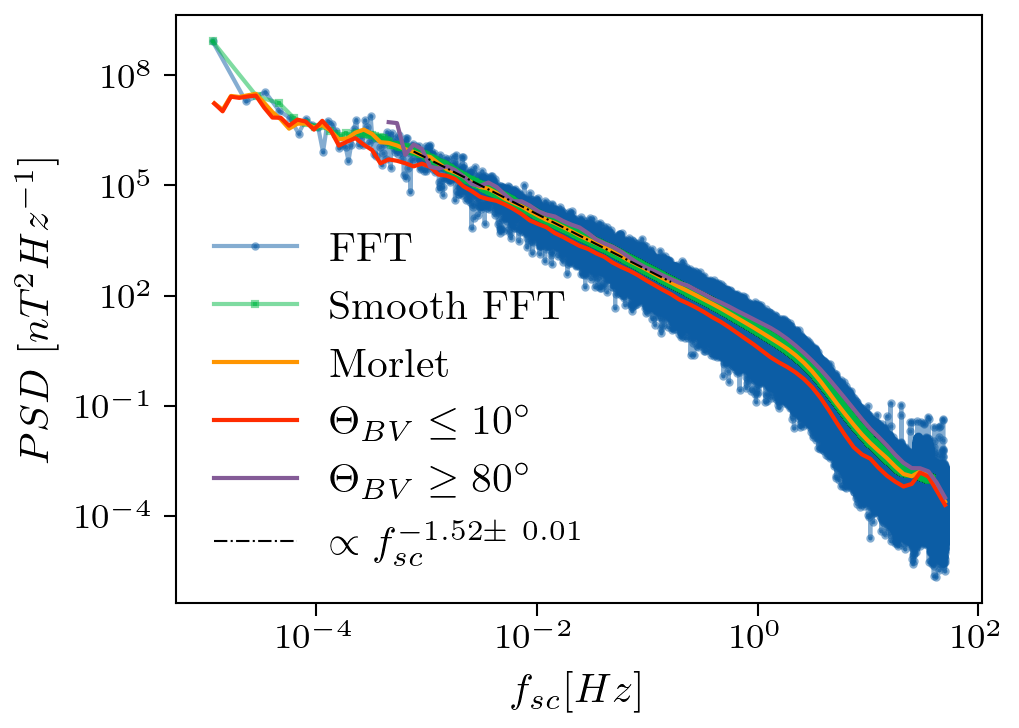

In [27]:
# Define limits of p-law fit
x0, xf                 = 8e-4, 2e-1
inset_f_size           = 10



# Define figure labels
ylabel, xlabel = r'$PSD~ [nT^{2} Hz^{-1}]$', r"$f_{sc} [Hz]$"


# init Figure
fig, ax                              = figs.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = figs.inset_axis_params(size = inset_f_size)


# Plot Trace FFT PSD
ax.loglog(fft_freqs, fft_PSD, ls='-', ms=1, alpha=0.5, label ='FFT')
# Plot  smoothed Trace FFT PSD
ax.loglog(F_mean,   smoothed_FFT_PSD, ls='-', ms=1, alpha=0.5, label ='Smooth FFT')

# Plot morlet wavelet PSD
ax.loglog(freqs, PSD,ls='-',ms=0, label ='Morlet')

# Plot morlet prallel wavelet PSD,
leg_par =r'$\Theta_{BV} \leq {%d}^{\circ} $'  %(par_thresh)
ax.loglog(freqs, PSD_par,ls='-',ms=0, label =leg_par)

# Plot morlet perpendicular wavelet PSD
leg_per =r'$\Theta_{BV} \geq {%d}^{\circ} $'  %(per_thresh)
ax.loglog(freqs, PSD_per,ls='-',ms=0, label =leg_per)

# Apply p-law fit on 
fit1, s1, e1, x1, y1  = func.find_fit(freqs,PSD, x0, xf)
# Define legend
lab_name =r'$\propto  f_{sc}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit1[0][1],2), round(np.sqrt(fit1[1][1][1]),2))

ax.loglog(x1[s1:e1],fit1[2], 'k-.', lw=0.5,label=lab_name)


# axins2 = ax.inset_axes([0.64, 0.61, 0.35, 0.35])
# axins2.yaxis.set_label_position("left")
# axins2.xaxis.set_label_position("bottom")
# axins2.yaxis.tick_left()
# axins2.xaxis.tick_bottom()

# axins2.tick_params(**minor_tick_params)
# axins2.tick_params(**major_tick_params)


ax.legend()

# Estimate PVI Timseries

(0.0, 27.290468876496455)

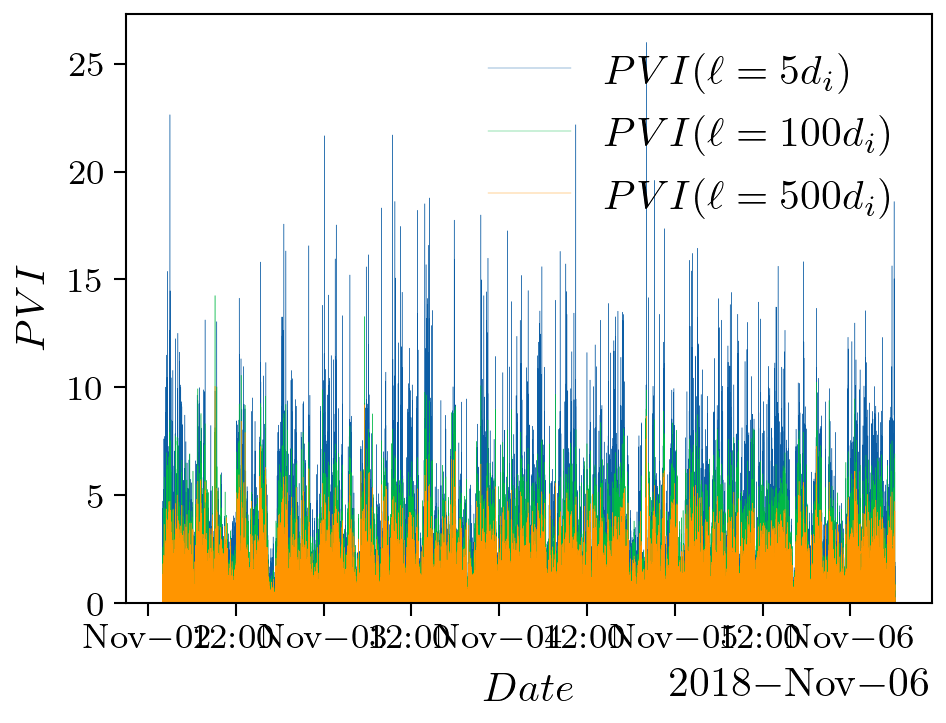

In [5]:
# User defined parameters
hours                  = 4                             # Averaging window in denominator (Hours)
hmany                  = [5, 100, 500]               # Estimate PVI timeseries using a lag of \ell =hmany*di
B_df                   = final['Mag']['B_resampled']
V_df                   = final['Par']['V_resampled']

#
di                     = final['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw                    = final['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval

# Define figure labels
ylabel, xlabel         = r'$PVI$',  r"$Date$"
inset_f_size           = 7



# Run function
PVI_ts                 =turb.estimate_PVI(B_df,
                                           hmany, 
                                           di,
                                           Vsw,
                                           hours,
                                           PVI_vec_or_mod='vec'
                                          )


# init Figure
fig, ax  = figs.initializeFigure(ylabel, xlabel, '1col')

for kk in range(len(hmany)):
    ax.plot(PVI_ts['PVI_'+str(hmany[kk])], ls='-', ms=0, lw=0.1, label =r'$PVI(\ell= {%d} d_{i})$'%(hmany[kk]))
    
    # # Estimate PDF of PVI
    # res =func.pdf(PVI_ts['PVI_'+str(hmany[kk])].dropna().values, nbins, loglog, density)
    # ax2.semilogy(res[0], res[1], ls='-', ms=0, lw=0.1,c ='C'+str(kk))
    # ax2.set_ylabel(r'$p(PVI)$')
    # ax2.set_ylabel(r'$PVI$')
    


ax.legend(loc=0, )
ax.set_ylim([0,None])


# Superposed epoch analysis
- For more information check (https://github.com/nsioulas/SEA)


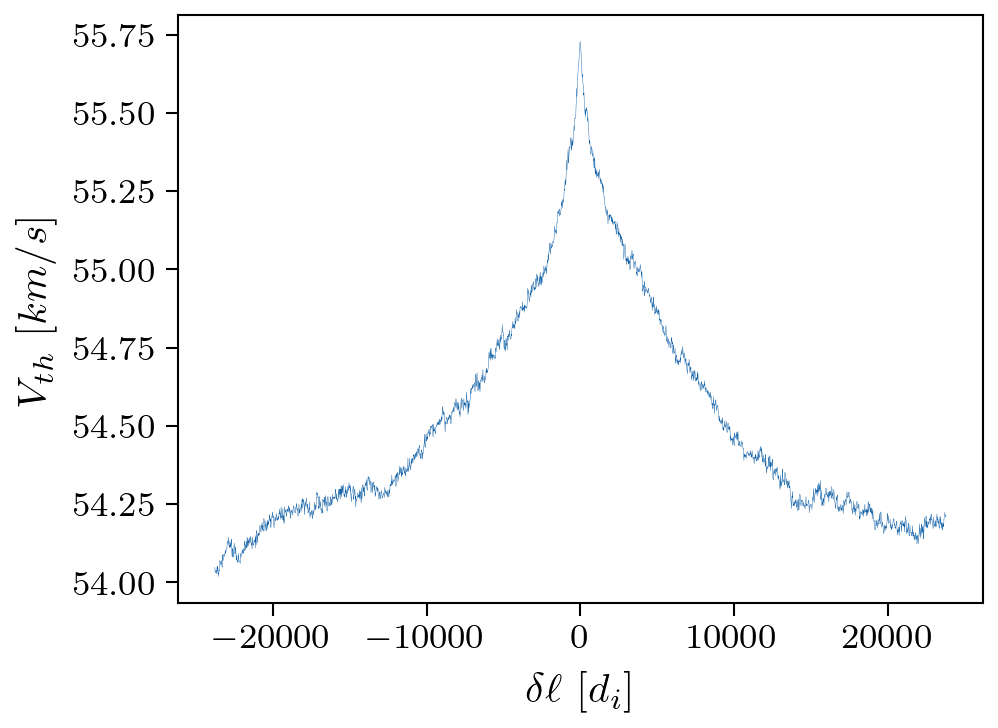

In [6]:
# user defined parameters
time_around        = '1000s'   # Time around identified events
which_one          =  'Vth'    # Parameter to be plotted on y axis
mean_or_median     =  0        # Estimate mean (1) or median (0) of events
resample_rate      =  '800ms'  # Cadence of joined timeseries

# you can actually aplly multiple conditions
condit_variables   = ['PVI_5']#, 'sigma_r']
conditions         = [['>=']]#, ['>=','<='] ]
threshold_values   = [[1]]#, [-0.15, 0.1]]


ylabel, xlabel     = r'$V_{th} ~[km/s]$',  r"$\delta \ell ~[d_i]$"


# Merge the two dfs
f_df = PVI_ts.resample(resample_rate ).mean().join(
     V_df.resample(resample_rate ).mean()
)


# run SEA function
xvals, yvals, y_std, y_std_err_mean  = SEA(f_df,
                                          condit_variables,
                                          threshold_values,
                                          conditions,
                                          time_around,
                                          which_one,
                                          mean_or_median,
                                          resample_rate)



# convert temporal lag to spatial and normalize with di
di_lag    = Vsw*xvals/di

# init Figure
fig, ax   = figs.initializeFigure(ylabel, xlabel, '1col')

ax.plot(di_lag, yvals, ls='-', ms=0, lw=0.1)
    

# Estimate Structure Functions ($SF^{q}$) and Scale dependent Kyrtosis

In [30]:
# User defined parameters

max_hours   = 8
max_qorder  = 7
qorder      = np.arange(1, max_qorder)

B_df        = final['Mag']['B_resampled']
V_df        = final['Par']['V_resampled']
di          = final['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw         = final['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval


# Estimate lags
dt          = pd.to_timedelta(pd.infer_freq(B_df.index)).total_seconds()
max_lag     = int((max_hours*3600)/dt)
tau_values  = 1.2**np.arange(0, 1000)
max_ind     = (tau_values<max_lag) & (tau_values>0)
tau_values  = np.unique(tau_values[max_ind].astype(int))


# Sfuncs
result      = turb.structure_functions(tau_values, qorder, B_df.values) 

# Also estimate x values in di
l_di        = (tau_values*dt*Vsw)/di

# Estimate SDK
SDK         = result.T[3]/result.T[1]**2

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot



30-Jan-23 18:29:19: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
30-Jan-23 18:29:19: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


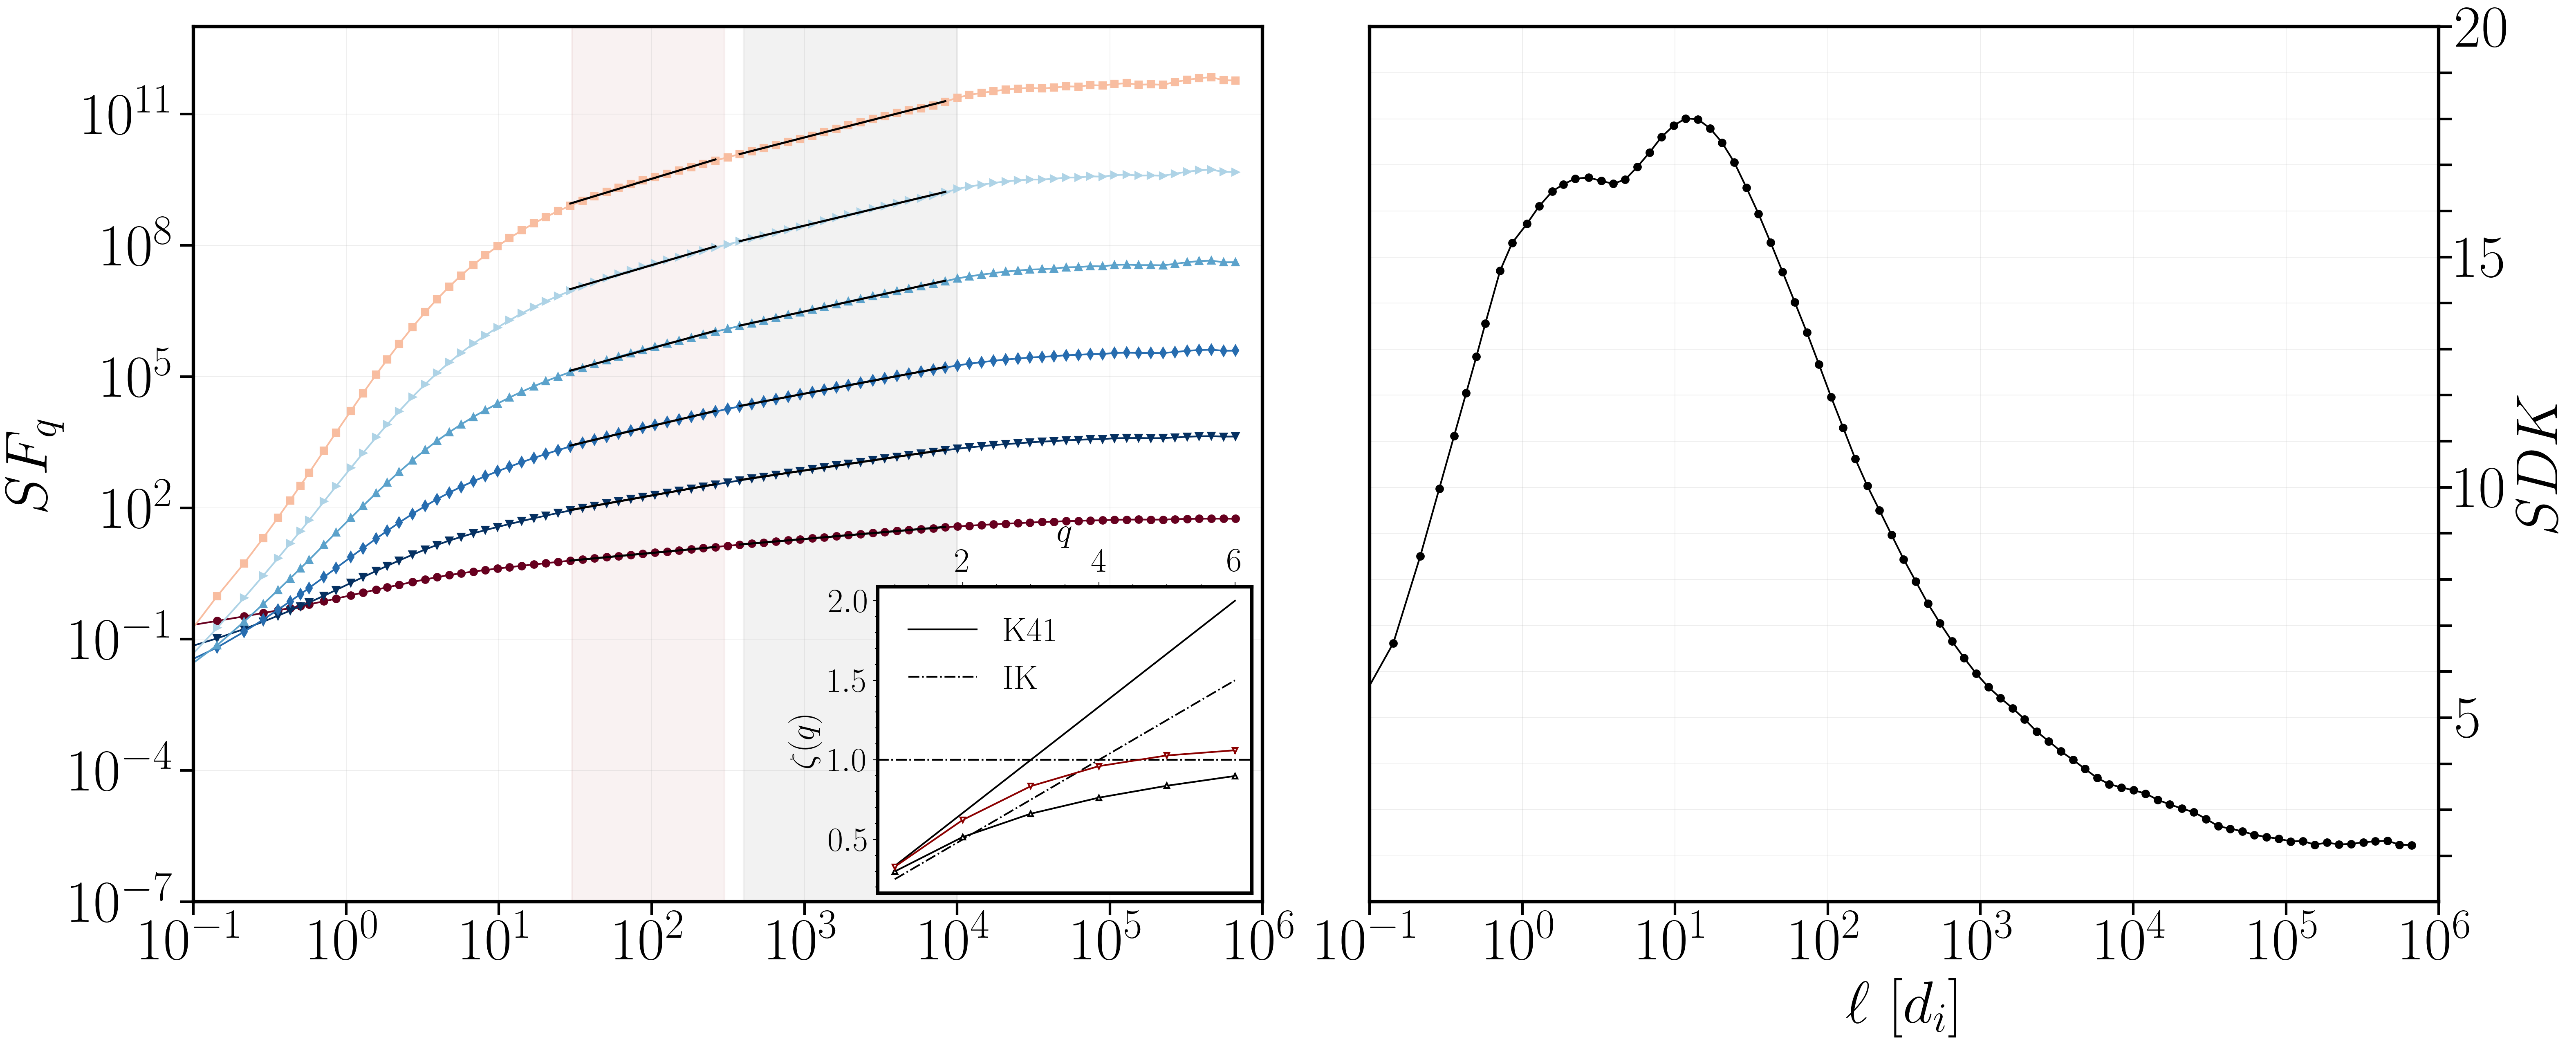

In [119]:
x01, xf1       = 400, 10000
x02, xf2       = 30, 300


f_size         = 35
inset_f_size   = 20
xlabel, ylabel = r'$SF_q$', r'$\ell~[d_i]$'
titles         = [r'$\theta_{BV} \leq 10^{\circ}$', r'$\theta_{BV} \geq 80^{\circ}$']

ylimits        = [1e-7, 1e13]
xlimits        = [1e-1, 1e6]


# Initialize figures
fig, ax                              = figs.initializeFigure_1by_2_noshare_y(xlabel, ylabel,width='1col', height=None,share_y=0)
col                                  = figs.create_colors(len(result.T))
minor_tick_params, major_tick_params = figs.inset_axis_params(size = inset_f_size)

# IK , K41 linear scalings
x_IK, y_IK = turb.IK_linear_scaling(len(result.T))
x_K41, y_K41 = turb.K41_linear_scaling(len(result.T))


for i in range(len(result.T)):
    
    # Assign Sfuncs to x,y variables
    x,y   = l_di, result.T[i]

    #if i==0:
        #ax[0].loglog(x,y,c='k', ms=4, ls='-',label =titles[1])
    ax[0].loglog(x,y, c=col[i-1], ms=4, ls='-')
    
    # Apply fit on two ranges on SFq
    fit1, s1, e1, x1, y1 = func.find_fit(x,y,x01,xf1)
    fit2, s2, e2, x2, y2 = func.find_fit(x,y,x02,xf2)

    lab_name =r'$\propto  \ell_{||}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit1[0][1],2), round(np.sqrt(fit1[1][1][1]),2))
    ax[0].loglog(x1[s1:e1],fit1[2], c='k', ls='-', lw=1.2, ms=0)#,label=lab_name)
    
    lab_name =r'$\propto  \ell_{||}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit2[0][1],2), round(np.sqrt(fit2[1][1][1]),2))
    ax[0].loglog(x2[s2:e2],fit2[2], c='k', ls='-', lw=1.2, ms=0)#,label=lab_name)


# Plot SDK
ax[1].loglog(x, SDK,c='k',  ms=4, ls='-')#,label=lab_name)

    
# Create inset  
axins2 = ax[0].inset_axes([0.64, 0.01, 0.35, 0.35])
axins2.yaxis.set_label_position("left")
axins2.xaxis.set_label_position("top")
axins2.yaxis.tick_left()
axins2.xaxis.tick_top()


for j in range(2):
    ax1=ax[j]


    fit_par =[]
    fit_per =[]
    fit_par_err =[]
    fit_per_err =[]
    if j==0:
        # Plot inset
        axins2.plot(x_K41, y_K41, c ='k', ls='-', ms=0, label ='K41')
        axins2.plot(x_IK, y_IK, c ='k', ls='-.', ms=0, label ='IK')
        
        colors         = 'k'
        xstart, xfinal = x01, xf1
    else:
        colors = 'darkred'     
        xstart, xfinal = x02, xf2
        
    for h in range(len(result.T)):
        x, y   = l_di, result.T[h]

        fit1, s1, e1, x1, y1 =func.find_fit(x, y , xstart, xfinal)
        fit_par.append(fit1[0][1])
        fit_par_err.append(np.sqrt(fit1[1][1][1]))

    axins2.errorbar(x_K41, fit_par,yerr=fit_par_err,  c=colors,mfc='w', ls='-') 
    
    # Add shaded area
    ax[0].axvspan(xstart, xfinal, alpha=0.05, color=colors)
    

  
                
    # Inset axis properties
    axins2.legend(frameon=0, loc=0,ncol=1, fontsize =inset_f_size)  
    axins2.set_ylabel(r'$\zeta(q)$', fontsize =inset_f_size) 
    axins2.set_xlabel(r'$q$', fontsize =inset_f_size) 
    axins2.axhline(y=1, color ='k', ls='-.') 
    axins2.tick_params(**minor_tick_params)
    axins2.tick_params(**major_tick_params)

    # Main axis
    ax1.tick_params(axis='both', which='major',bottom=1, top=0, right=0,left=1,direction='out',labelsize=38); 
    ax1.legend(loc=2, fontsize =30, frameon=0)

    
    if j==0:
        ax[j].set_ylabel(r'$SF_q$', fontsize =f_size)

    
    # Tick parameters
    if j==0:
        ax1.tick_params(axis='both', which='major',left=1,right=0,bottom=1, top=0, direction='out',width=1.5, length=8, labelsize=f_size)
        ax1.tick_params(axis='both', which='minor',left=0,right=0,bottom=0, top=0, direction='out',width=1.5, length=8, labelsize='large')
    else:
        ax1.tick_params(axis='both', which='major',left=0,right=1,bottom=1, top=0, direction='out',width=1.5, length=8, labelsize=f_size)
        ax1.tick_params(axis='both', which='minor',left=0,right=0,bottom=0, top=0, direction='out',width=1.5, length=8, labelsize='large')
        
    ax1.xaxis.set_ticks([0.1, 1, 10, 10**2, 10**3, 10**4, 10**5, 10**6])  
    ax1.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$', r'$10^{5}$',r'$10^{6}$'])
    

    
    # Axis grids
    ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
    ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.xaxis.grid(True, "major", linewidth=.1, ls='-');    

    ax1.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.yaxis.grid(True, "major", linewidth=.1, ls='-');
    ax1.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
    ax1.xaxis.grid(True, "major", linewidth=.1, ls='-'); 
    
    # axis limits
    ax1.set_xlim(xlimits)
    ax1.set_ylim(ylimits)
    
    # xlabel
    ax[1].set_xlabel(r'$\ell~[d_{i}]$', fontsize =f_size)

    
# Fix ax[1]
ax[1].set_ylim([1, 20])
ax[1].yaxis.set_ticks([  10])  
ax[1].set_yticklabels([ r'$10^{1}$'])
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylabel(r'$SDK$', fontsize =f_size)
ax[1].set_yscale('linear')